In [1]:
# Autoreload ensures that your python-files stay up-to-date: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Move back to the root directory
%cd ..

/app


# Data Exploration

This notebook shows an example of data exploration.

Data exploration is at the beginning of any Machine Learning project, and helps you familiarise with the problem at hand. You can generate insights like:
* How does a traditional data sample look like?
* How does the biggest bulk of our dataset look like? --> Helps to tackle the "low hanging fruits"
* Are their outliers in our dataset and how do they look like? --> important for "sensitive applications" where outliers are as important as an average sample
* What are the data's properties (i.e. dimensions, type of data, ...)

In [2]:
import re
import csv
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint, choice
from PIL import Image, ImageOps
from pathlib import Path
from collections import Counter

## Manual exploration

In a first iteration, we'll go manually over the data to generate some insights.

### 1. Visualise the data

First and foremost, let's see how the data looks like! Visualise a random subset of images from our dataset.

In [3]:
# Load in all the data paths using pathlib
files = sorted((Path.cwd() / 'data/data/minifigures').glob('*.png'))
n_files = len(files)
n_files

6801

In [6]:
# Remove the samples with a faulty name
files = [path for path in files if path.name[0] != "."]
n_files = len(files)
n_files

6801

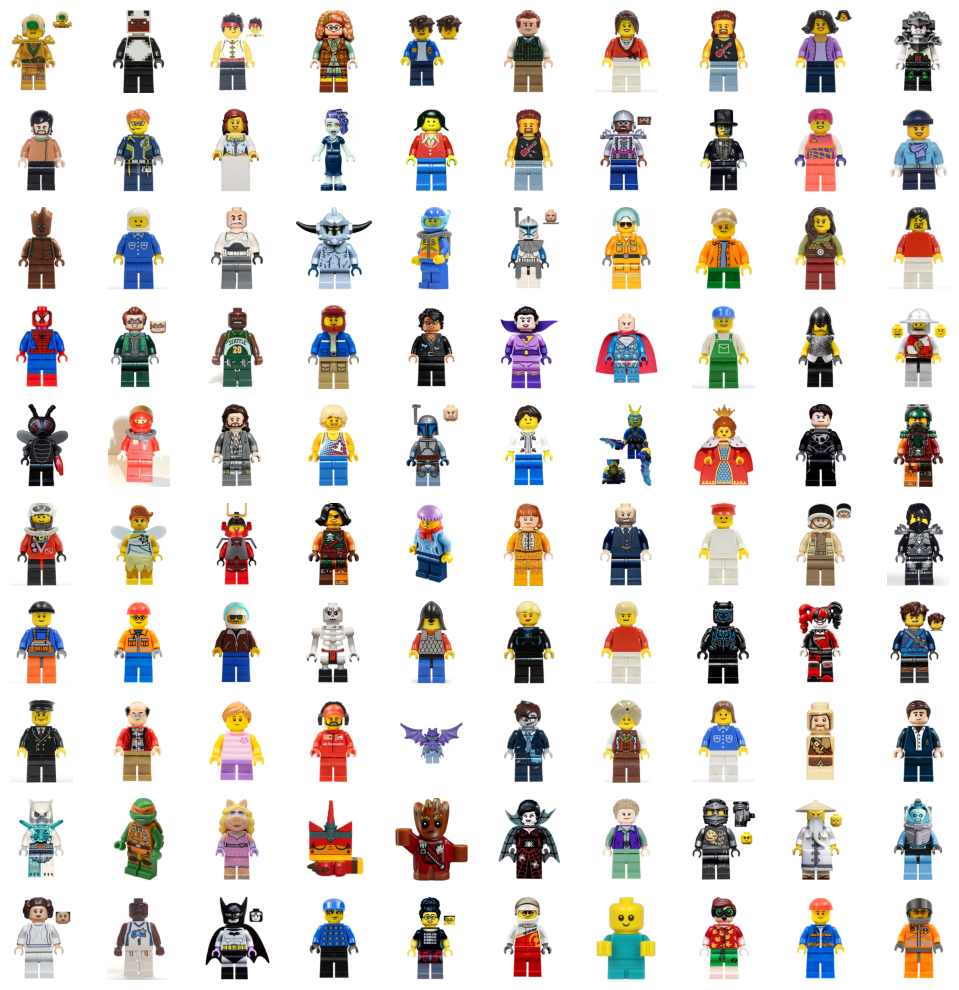

In [7]:
# Visualise 100 images at random
_,axs=plt.subplots(10,10,figsize=(10,10))
for i in range(10*10):
    axs[i%10,i//10].imshow(Image.open(files[randint(0, n_files-1)]))
_ = [ax.set_axis_off() for ax in axs.ravel()]
plt.tight_layout()
plt.show()

### 2. Dataset distribution

Next, when looking into the images' names, we notice that some of them have a prefix, indicating from which dataset they are. Let's extract this prefix and see what type of minifigures we can expect the most. 

In [9]:
# For most samples, there's a dataset prefix
files[200:220]

[PosixPath('/app/data/data/minifigures/air046a.png'),
 PosixPath('/app/data/data/minifigures/air048.png'),
 PosixPath('/app/data/data/minifigures/air050.png'),
 PosixPath('/app/data/data/minifigures/air051.png'),
 PosixPath('/app/data/data/minifigures/air052.png'),
 PosixPath('/app/data/data/minifigures/air053.png'),
 PosixPath('/app/data/data/minifigures/air054.png'),
 PosixPath('/app/data/data/minifigures/air055.png'),
 PosixPath('/app/data/data/minifigures/airdg001.png'),
 PosixPath('/app/data/data/minifigures/alp022.png'),
 PosixPath('/app/data/data/minifigures/alp024.png'),
 PosixPath('/app/data/data/minifigures/alp025.png'),
 PosixPath('/app/data/data/minifigures/alp027.png'),
 PosixPath('/app/data/data/minifigures/alp028.png'),
 PosixPath('/app/data/data/minifigures/aqu001a.png'),
 PosixPath('/app/data/data/minifigures/aqu006a.png'),
 PosixPath('/app/data/data/minifigures/aqu014a.png'),
 PosixPath('/app/data/data/minifigures/aqu015a.png'),
 PosixPath('/app/data/data/minifigures/

In [11]:
# Create a function to extract the prefix from a path
def extract_prefix(path:Path) -> str|None:
    """Extract the prefix from the Path."""
    name = path.with_suffix('').name
    prefix = re.search('^[a-z]+', name)
    if prefix:
        return prefix.group(0)
    return None
    
extract_prefix(files[123])

'ac'

In [12]:
# Generate all the prefixes
prefixes = [extract_prefix(p) for p in tqdm(files)]

# Show to top N prefixes
counts = Counter(prefixes)
if None in counts: del counts[None]

top_n = 10
prefixes_ = sorted(counts.items(), key=lambda x: x[1], reverse=True)
prefixes_[:top_n]

100%|██████████| 6801/6801 [00:00<00:00, 148442.54it/s]


[('cty', 898),
 ('sw', 823),
 ('sh', 714),
 ('njo', 660),
 ('cas', 267),
 ('twn', 261),
 ('col', 232),
 ('hol', 170),
 ('hp', 147),
 ('pi', 117)]

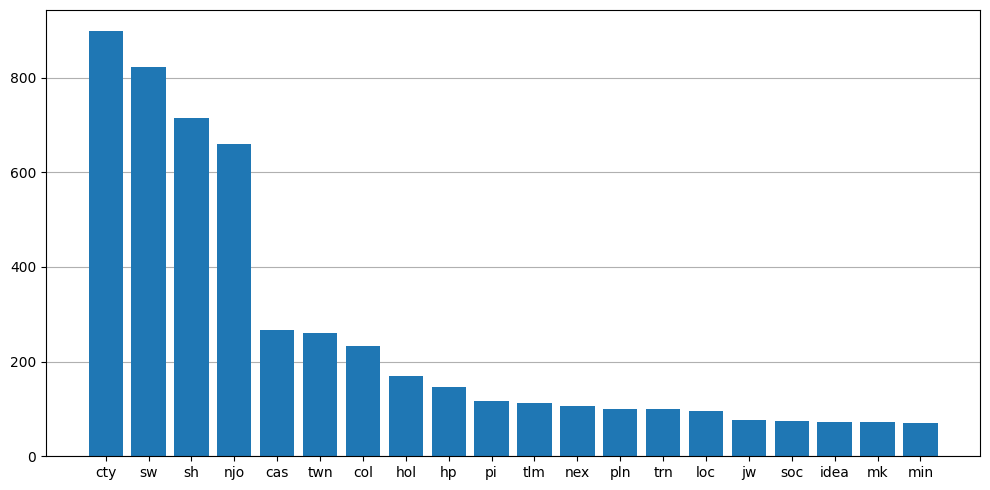

In [13]:
# Visualise dataset distribution
top_n = 20

plt.figure(figsize=(10,5))
plt.bar(range(top_n), [v for _,v in prefixes_[:top_n]], zorder=2)
plt.xticks(range(top_n), [k for k,_ in prefixes_[:top_n]])
plt.tight_layout()
plt.grid(axis='y')
plt.show()

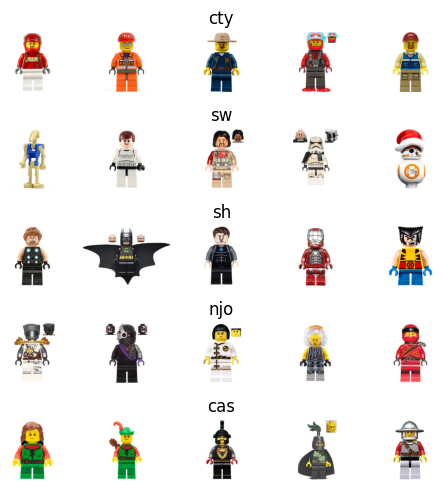

In [14]:
# Show examples for each top_n classes
top_n, n_col = 5, 5

_,axs = plt.subplots(top_n, n_col, figsize=(n_col,top_n))
for i in range(top_n):
    p, n = prefixes_[i]
    selection = [path for path,prefix in zip(files,prefixes) if prefix==p]
    for j in range(n_col):
        axs[i,j].imshow(Image.open(selection[randint(0,len(selection)-1)]))
        if j == (n_col//2): axs[i,j].set_title(p)
_ = [ax.set_axis_off() for ax in axs.ravel()]
plt.tight_layout()
plt.show()

### 3. Sizes

Images have different sizes, let's investigate what the size distribution is of our dataset. This is interesting to keep in mind for later, when we start building a Machine Learning model.

In [15]:
# Get the image's shapes
shapes = [Image.open(path).size for path in tqdm(files)]
x,y = zip(*shapes)

100%|██████████| 6801/6801 [01:04<00:00, 105.19it/s]


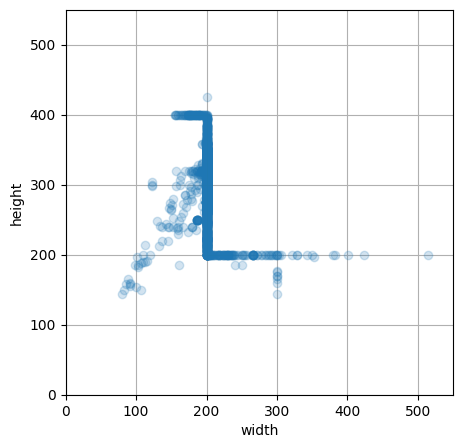

In [16]:
# Visualise the shapes
plt.figure(figsize=(5,5))
plt.scatter(x, y, alpha=0.2, zorder=2)
plt.xlabel('width'); plt.ylabel('height')
plt.ylim(0,550); plt.xlim(0,550)
plt.grid()
plt.show()

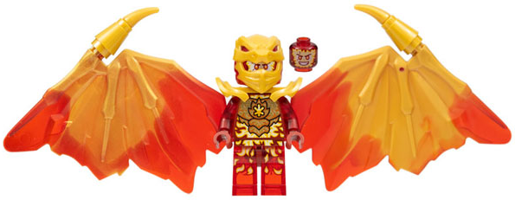

In [17]:
# Who's the tall one?
idx = [v>500 for v in x]
Image.open(files[idx.index(True)])

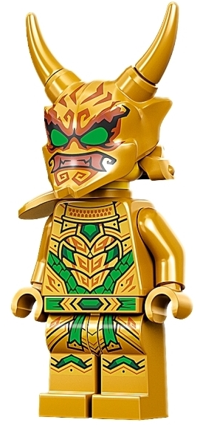

In [18]:
# Who's the wide one?
idx = [v>420 for v in y]
Image.open(files[idx.index(True)])

### 4. Labels

Next to the images themselves, we also have a `dataset.json` that contains the target labels of a few samples in our dataset. Let's have a look how this looks like!

This will show us that we're working with a rather imbalanced dataset, but that there are also already several samples for each individual label.

In [19]:
# Open up the dataset, show how many labels there are, and which unique labels exist
with open('data/data/dataset.json', 'r') as f:
    dataset = json.load(f)
labels = sorted({x for y in dataset.values() for x in y})
len(dataset), labels

(136,
 ['alien',
  'angry',
  'cape',
  'facial hair',
  'glasses',
  'happy',
  'hat',
  'helmet',
  'human',
  'robot'])

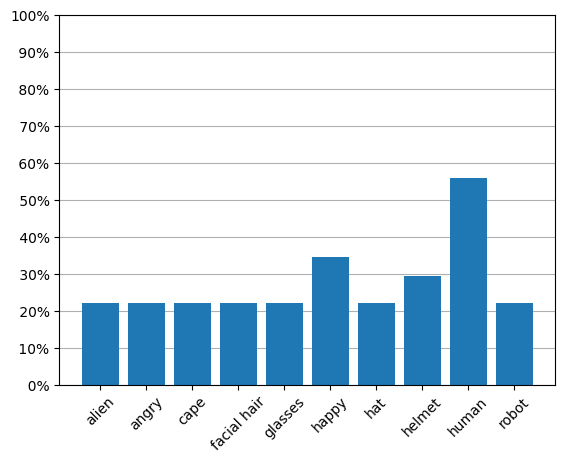

In [20]:
# Plot the label ratios
counts = Counter()
for v in dataset.values():
    counts.update(v)

plt.figure()
plt.bar(labels, [counts[l]/len(dataset) for l in labels], zorder=2)
plt.xticks(labels, rotation=45)
plt.yticks([i/10 for i in range(11)], [f"{10*i:3d}%" for i in range(11)])
plt.grid(axis='y')
plt.show()

## Advanced Analysis - FastDup

Luckily, it's often not necessary to iterate over your data manually. Nowadays you have plenty of data exploration libraries at your disposal. One of them is FastDup.

Analyse the dataset using the [FastDup](https://github.com/visual-layer/fastdup) library. Full documentation [here](https://visual-layer.github.io/fastdup/).

__Note:__ run `poetry add fastdup --group dev` first in the terminal to add it to your environment: 
* `Poetry` is the virtual environment we're currently running in (similarly to `conda` or `virtual environments`, but does a lot of dependency versioning and other cool stuff automatically for you!).
* To add new dependencies to our environment, we use the `add` option. However, several other options exist too. Find out using `poetry list`.
* The `--group dev` will install the dependency as a development dependency, since we'll only be using it during development.
* After installing, go have a look at how you `pyproject.toml` file changed!
* If you want to remove this package later, you can do this using `poetry remove fastdup`.

In [21]:
import fastdup

from IPython.display import HTML
from shutil import rmtree

In [22]:
# Remove if already exists
if Path("fastdup/run").is_dir():
    rmtree("fastdup/run")

# Run FastDup
fastdup.run(
    input_dir="data/data/minifigures", 
    work_dir='fastdup/run', 
    nearest_neighbors_k=5, 
    turi_param='ccthreshold=0.96',
)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-02-15 08:13:15 [INFO] Going to loop over dir data/data/minifigures
2023-02-15 08:13:16 [INFO] Found total 6801 images to run on
2023-02-15 08:14:03 [INFO] Found total 6801 images to run ontimated: 0 Minutes 0 Features
2023-02-15 08:14:08 [INFO] 5698) Finished write_index() NN model
2023-02-15 08:14:08 [INFO] Stored nn model index file fastdup/run/nnf.index
2023-02-15 08:14:11 [INFO] Total time took 55574 ms
2023-02-15 08:14:11 [INFO] Found a total of 218 fully identical images (d>0.990), which are 0.53 %
2023-02-15 08:14:11 [INFO] Found a total of 433 nearly identical images(d>0.980), which are 1.06 %
2023-02-15 08:14:11 [INFO] Found a total of 15199 above threshold images (d>0.900), which are 37.25 %
2023-02-15 08:14:11 [INFO] Found a total of 1700 outlier images         (d<0.050), which are 4.17 %
2023-02-15 08:14:11 [INFO] Min distance found 0.631 max distance 1.000
2023-02-15 08:14:11 [INFO] Running con

0

100%|██████████| 10/10 [00:00<00:00, 18.93it/s]

Stored similarity visual view in  fastdup/analysis/similarity.html



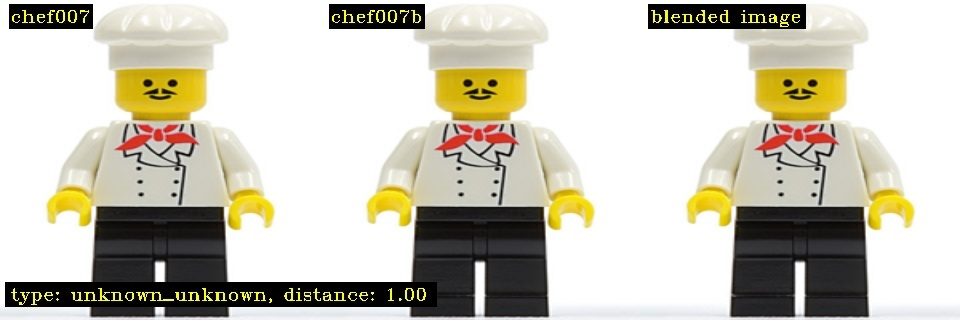
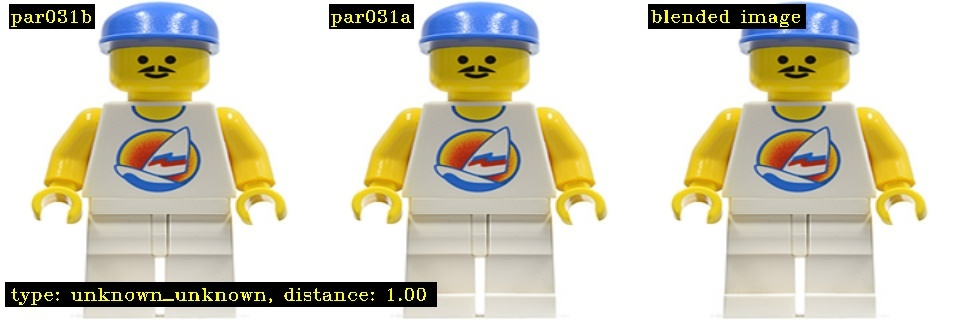
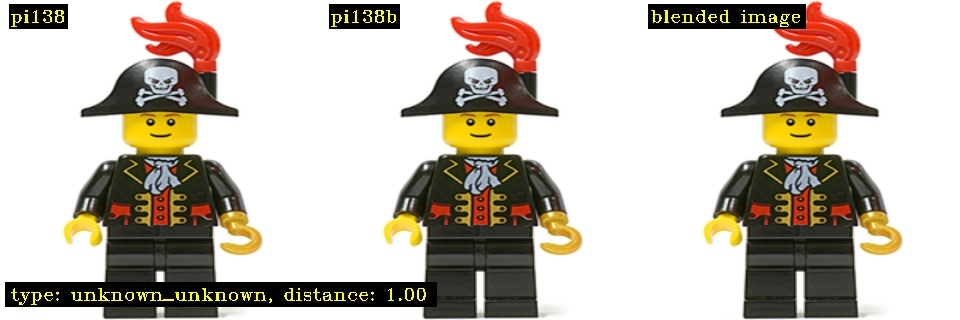
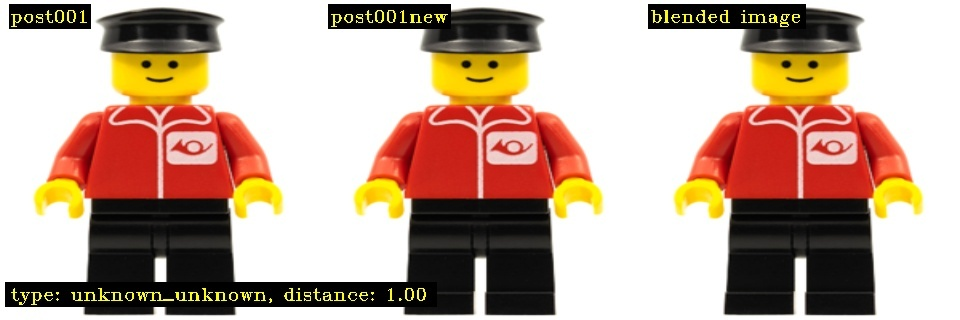
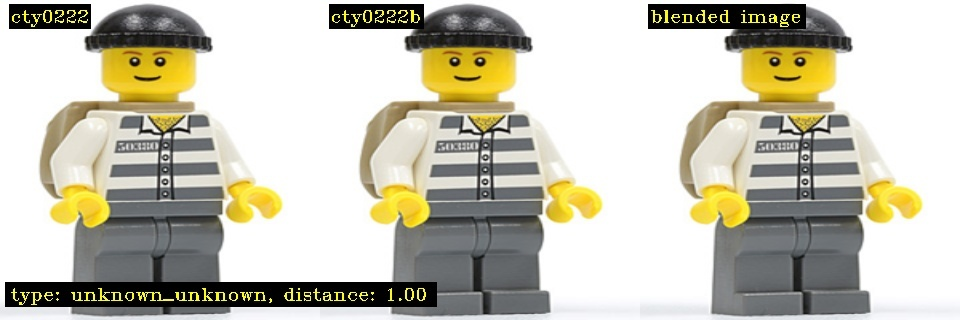
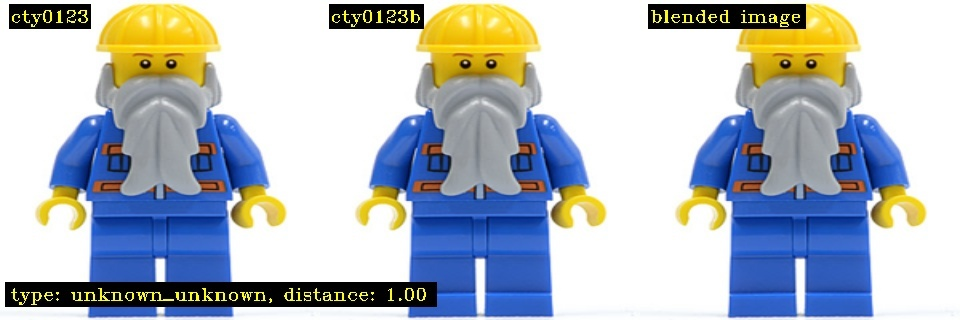
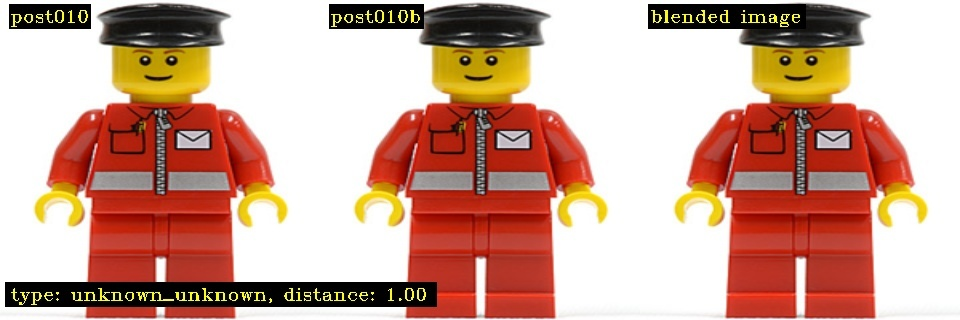
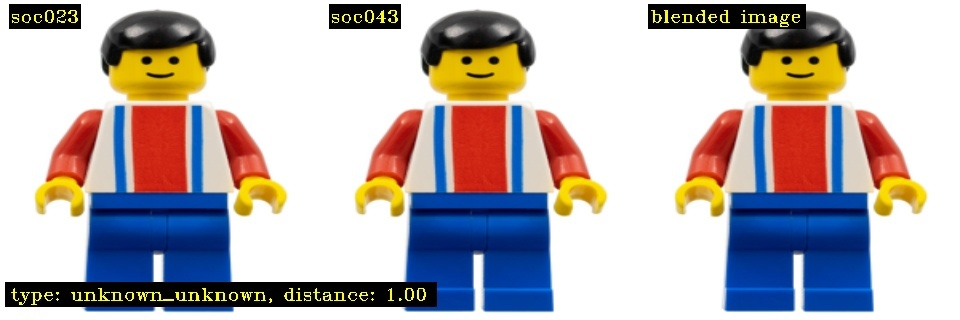
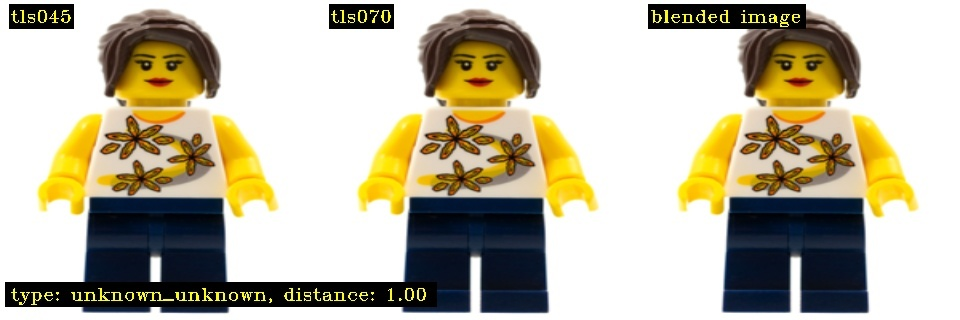

In [23]:
# Create a visual gallery of found duplicates
fastdup.create_duplicates_gallery(
    'fastdup/run/similarity.csv', 
    save_path='fastdup/analysis',
    num_images=10,
)
HTML(filename='fastdup/analysis/similarity.html')

100%|██████████| 10/10 [00:00<00:00, 8466.50it/s]

Stored outliers visual view in  fastdup/analysis/outliers.html



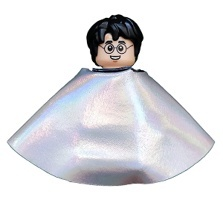
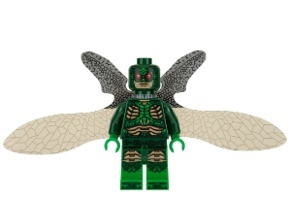
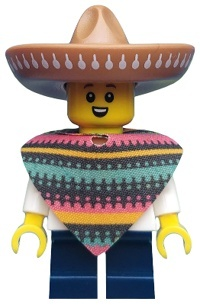
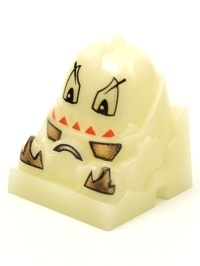
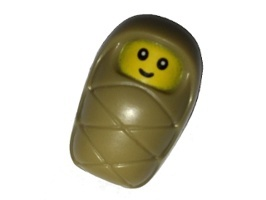
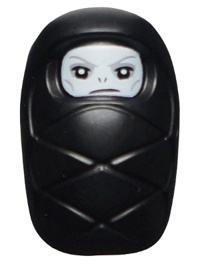
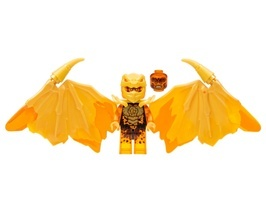
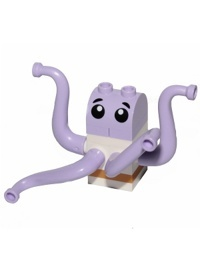
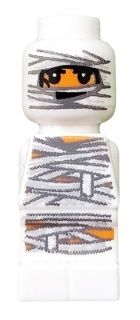
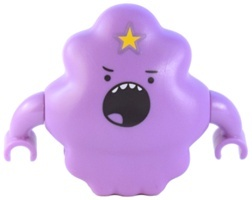

In [24]:
# Create a visual gallery of anomalies
fastdup.create_outliers_gallery(
    'fastdup/run/outliers.csv', 
    save_path='fastdup/analysis',
    num_images=10,
)
HTML(filename='fastdup/analysis/outliers.html')

100%|██████████| 10/10 [00:00<00:00, 20.25it/s]


Finished OK. Components are stored as image files fastdup/analysis/components_[index].jpg
Stored components visual view in  fastdup/analysis/components.html
Execution time in seconds 1.3



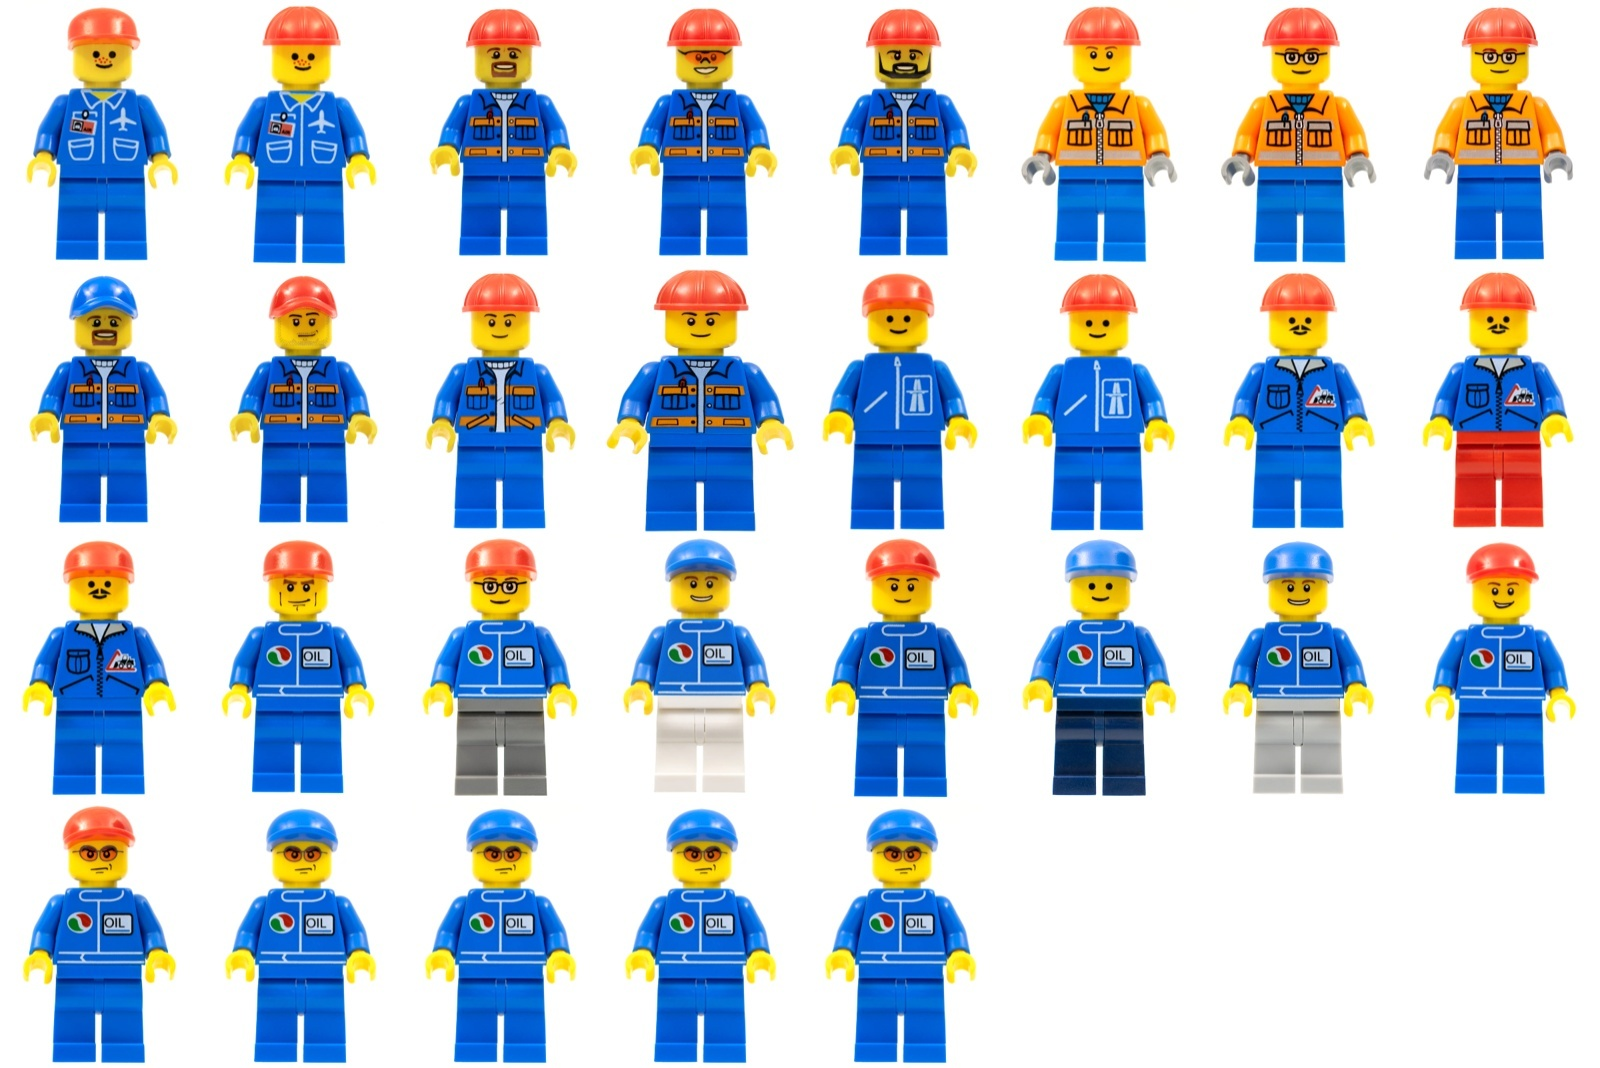
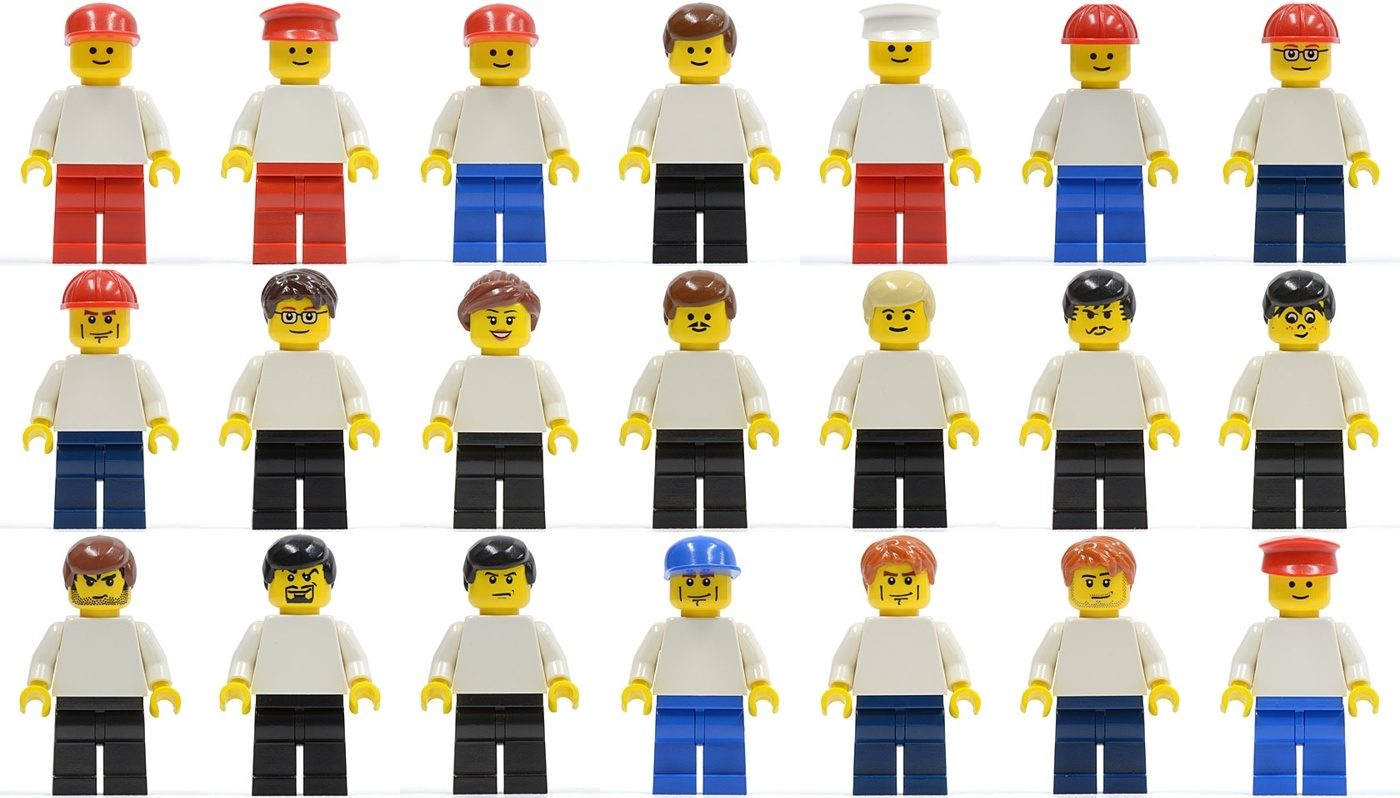
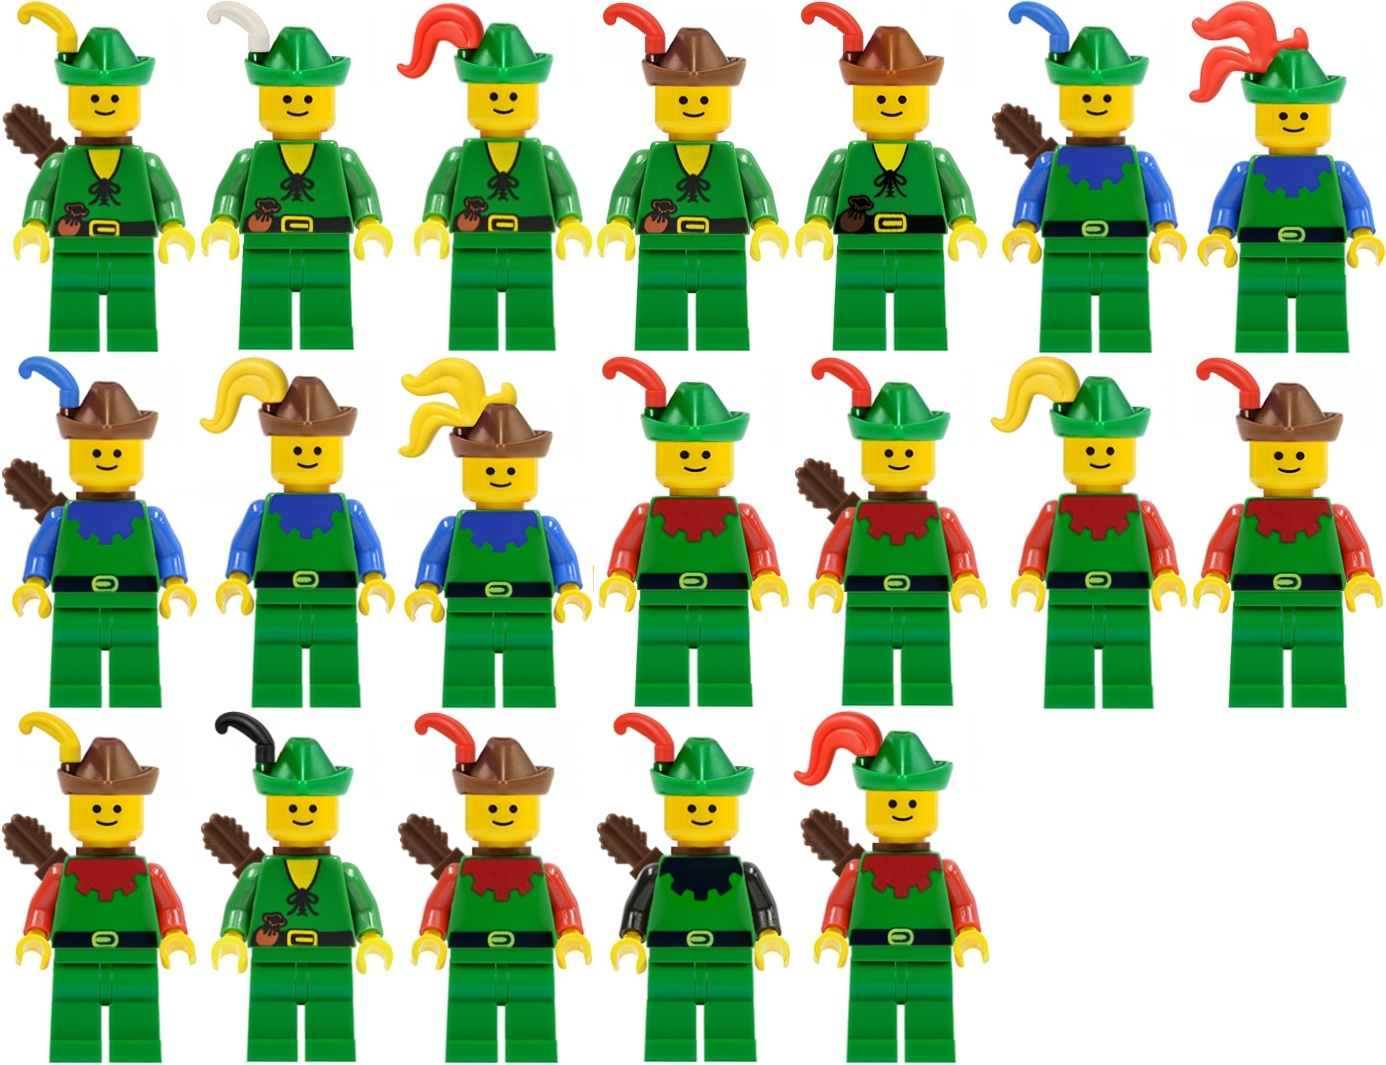
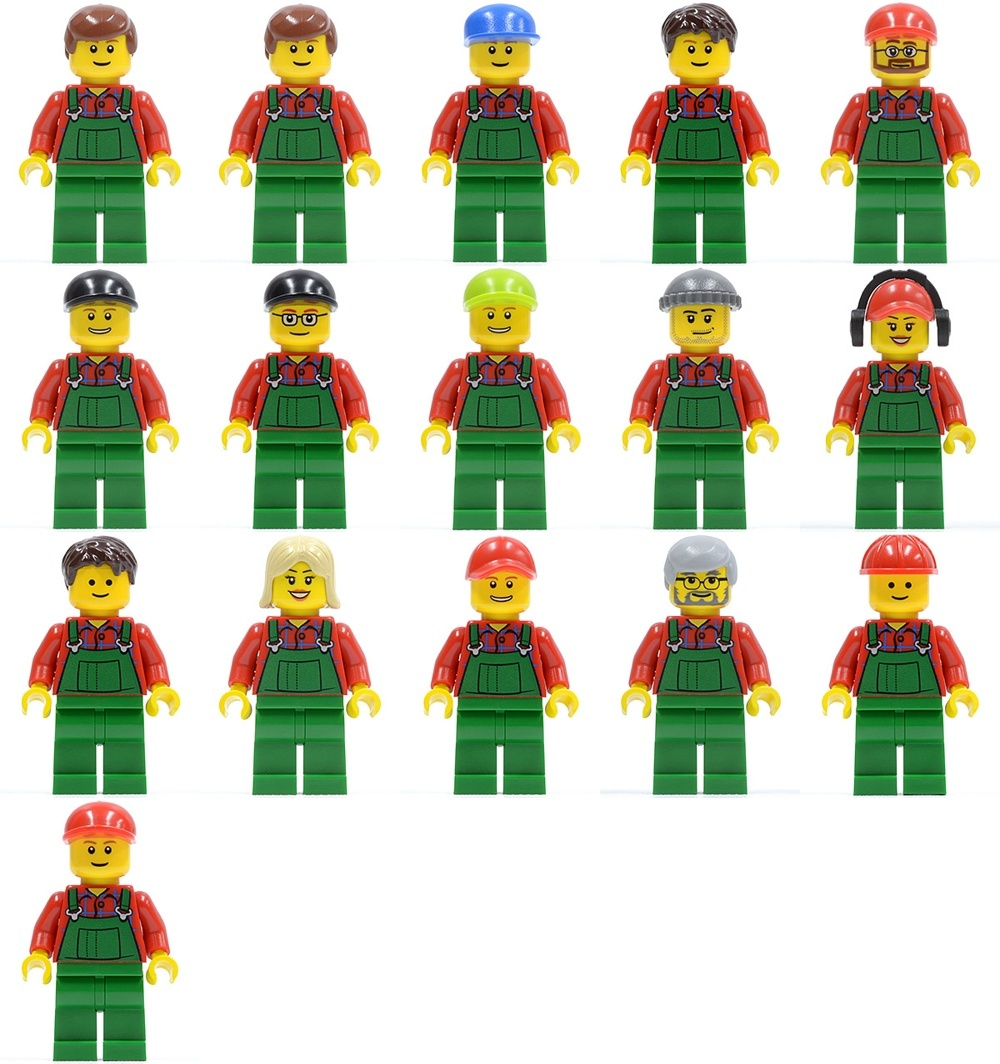
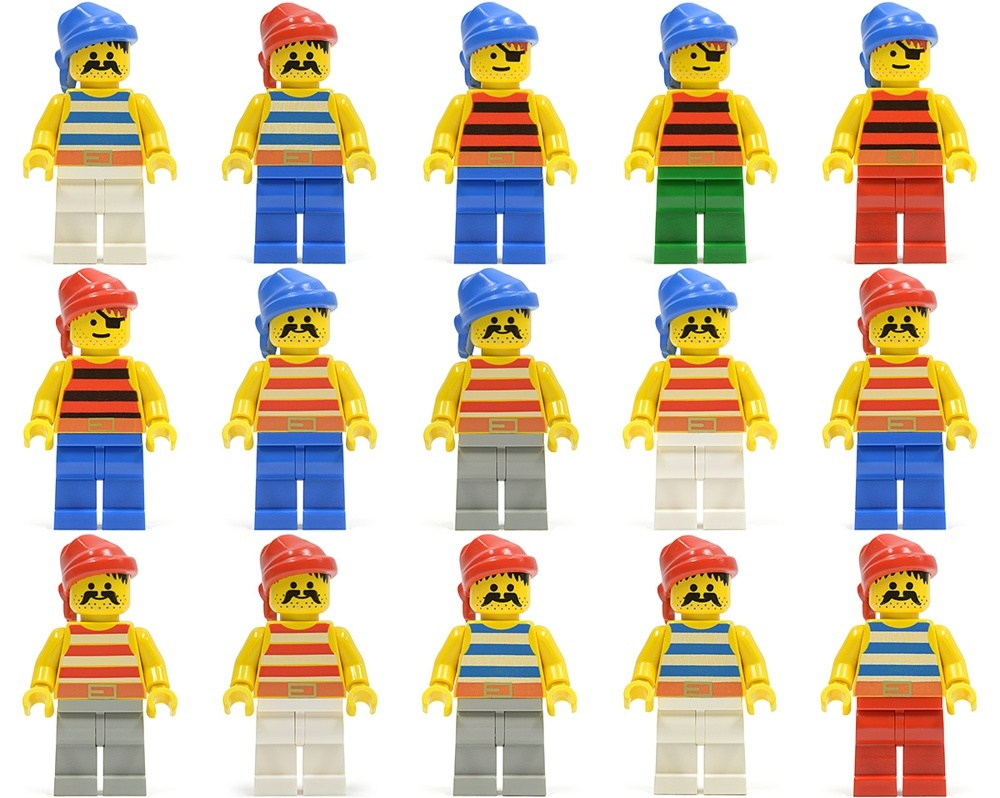
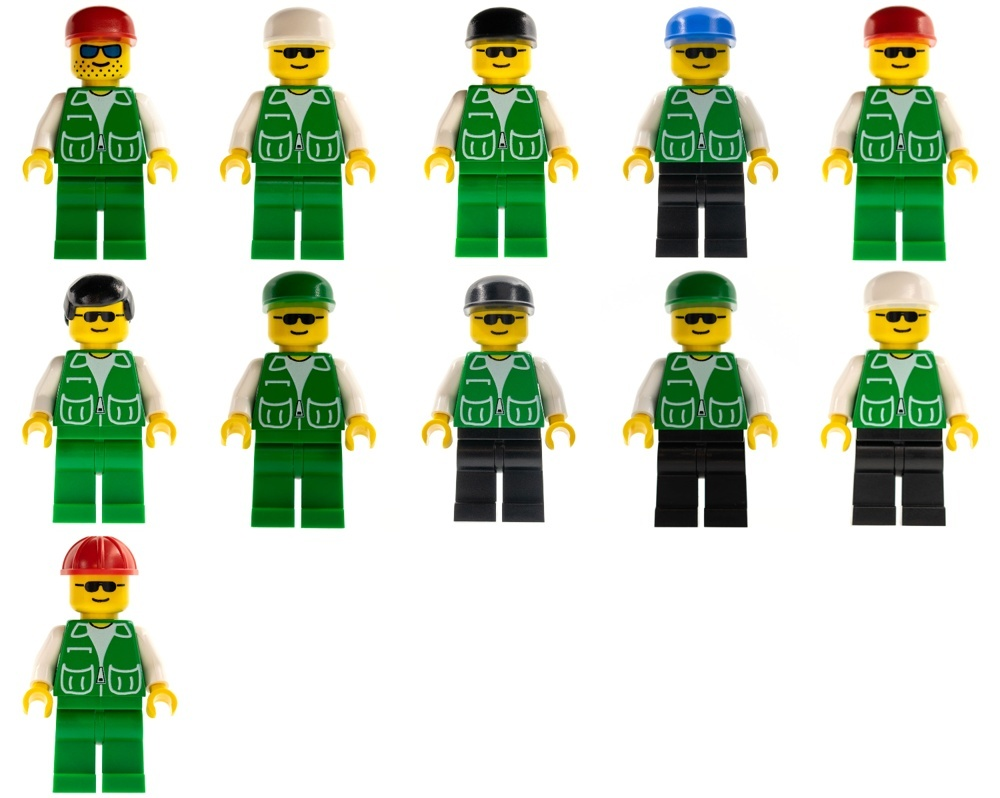
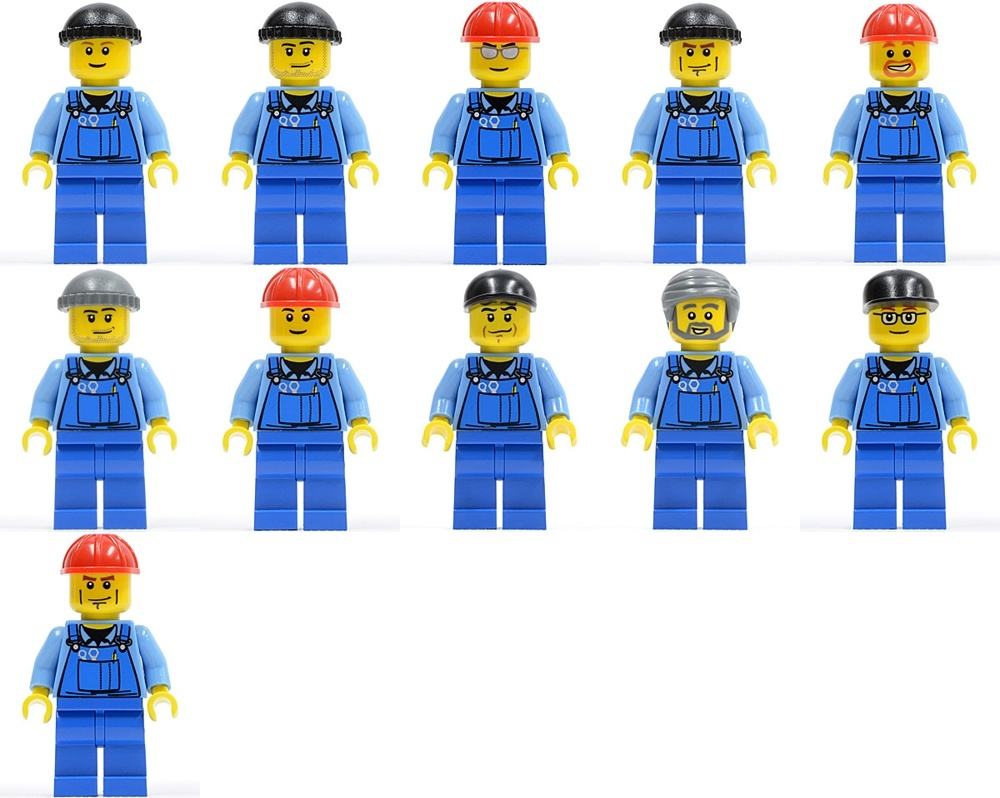
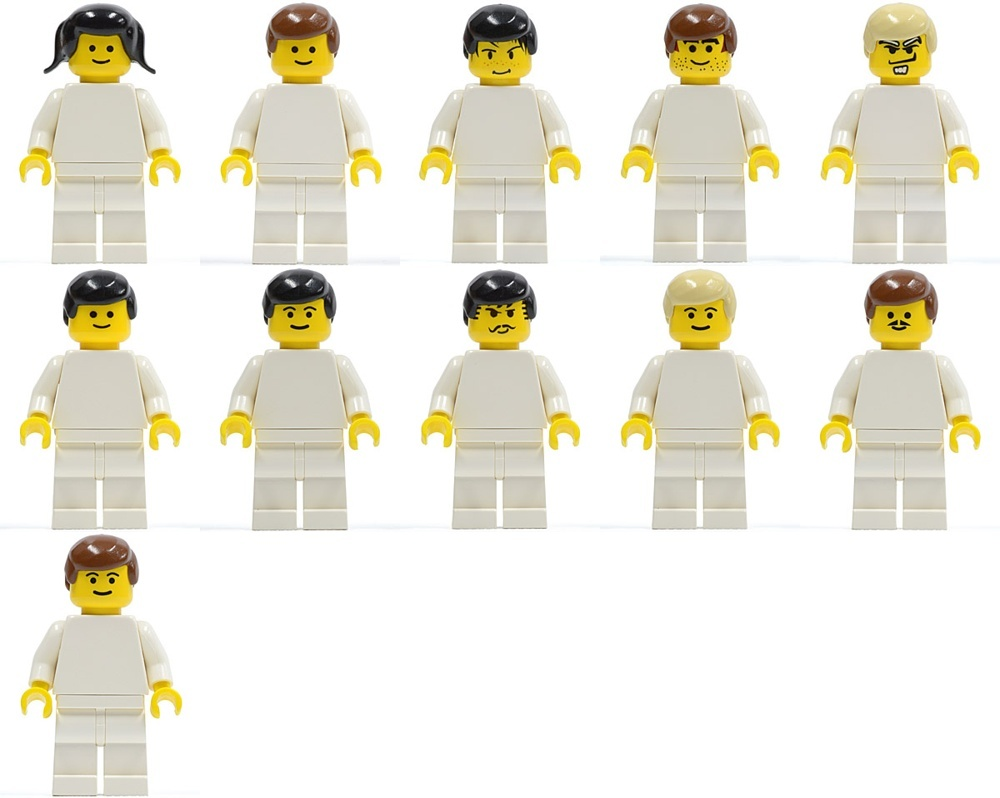
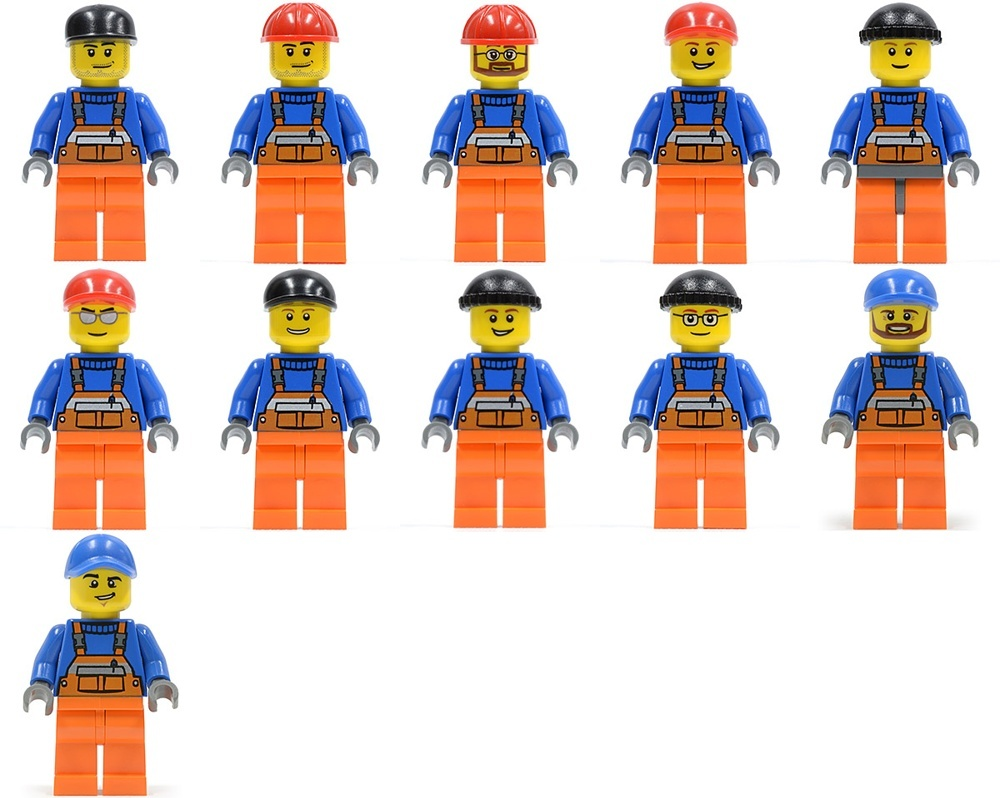
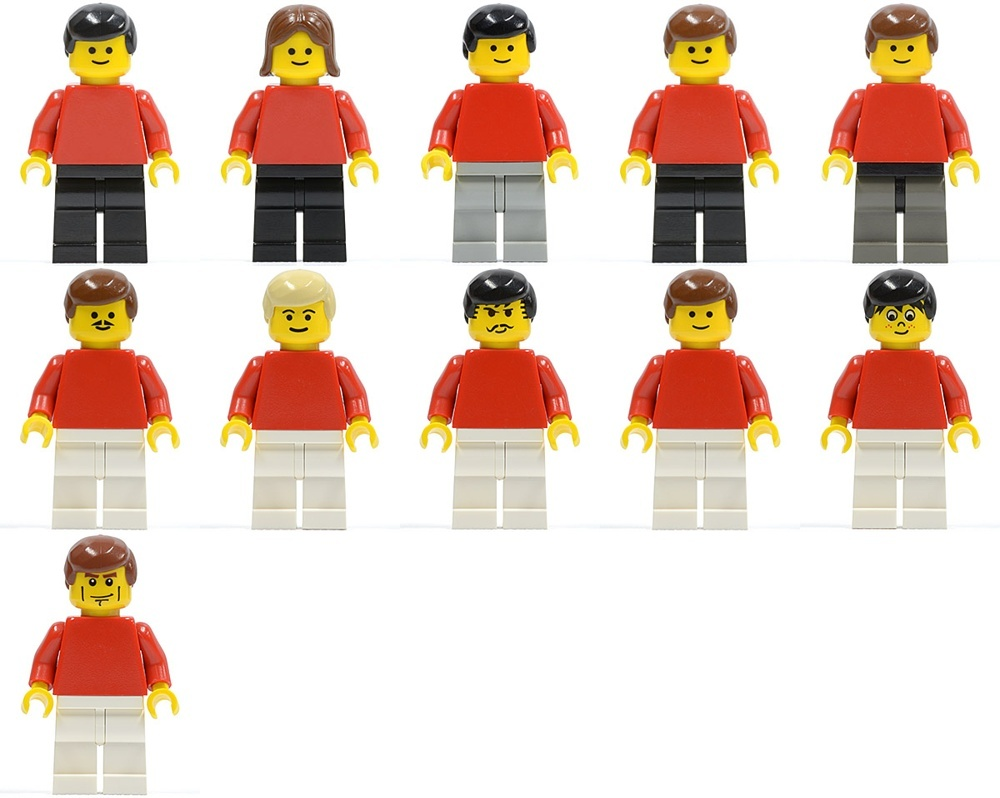

In [25]:
# Create visualiaiton of connected components
fastdup.create_components_gallery(
    'fastdup/run', 
    save_path='fastdup/analysis',
    num_images=10,
)
HTML(filename='fastdup/analysis/components.html')

Saved aspect ratio report to fastdup/analysis/aspect_ratio.html



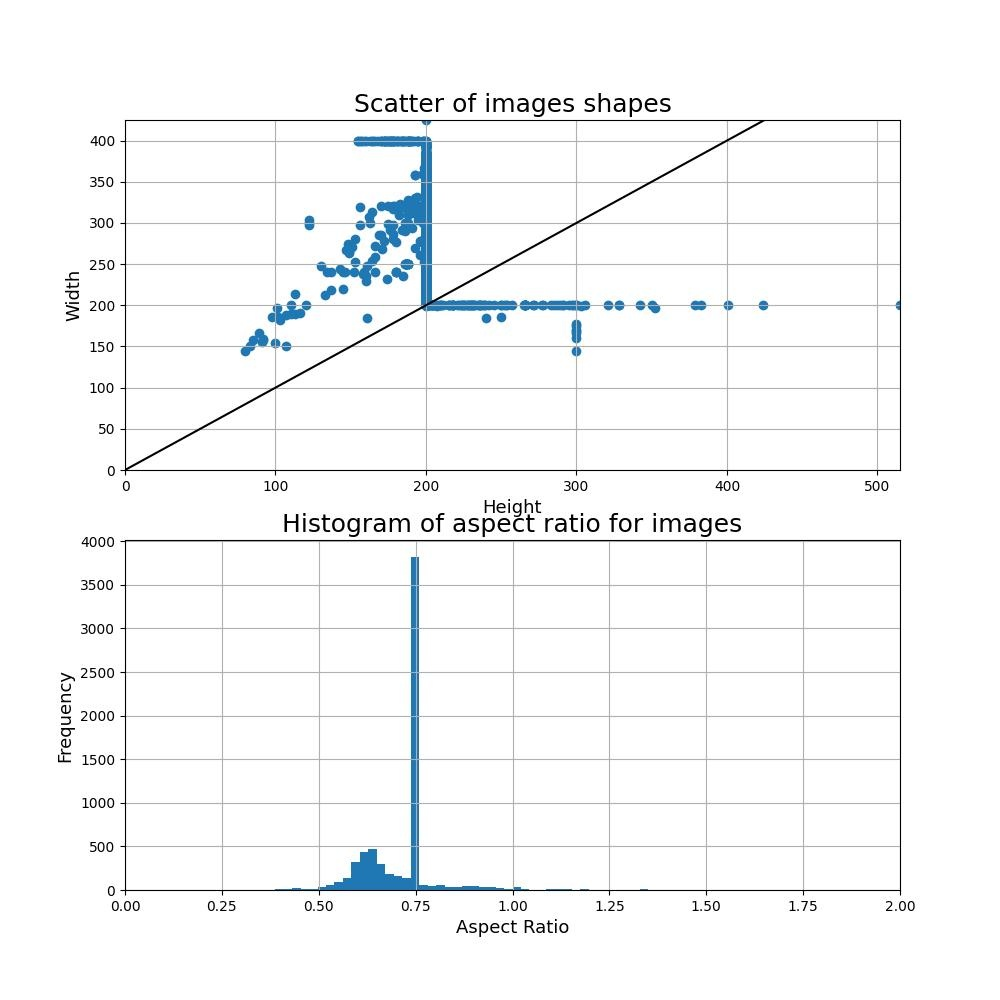
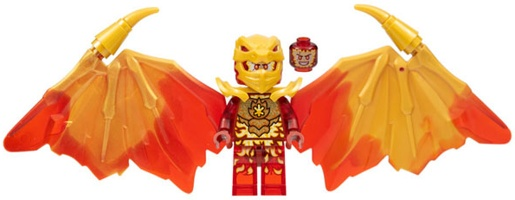
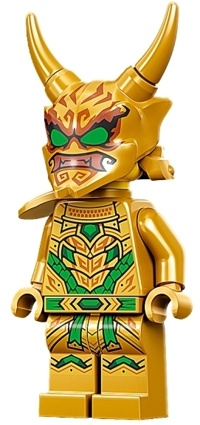

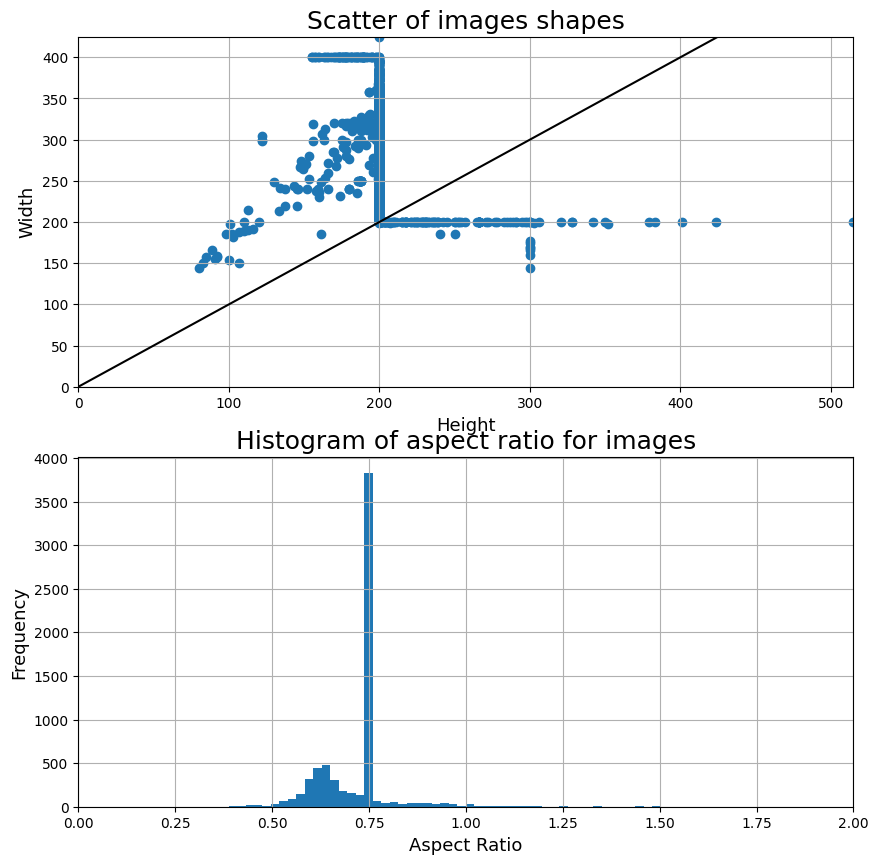

In [26]:
# Create aspect ratio gallery
fastdup.create_aspect_ratio_gallery(
    'fastdup/run', 
    save_path='fastdup/analysis',
)
HTML(filename='fastdup/analysis/aspect_ratio.html')

100%|██████████| 10/10 [00:00<00:00, 743.33it/s]

Stored size statistics view in  fastdup/analysis/size.html



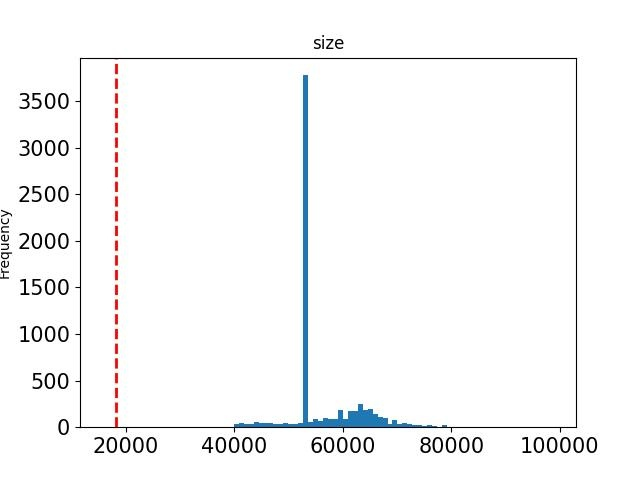
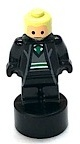
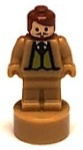
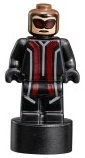
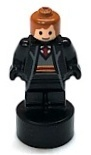
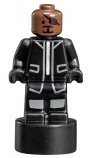
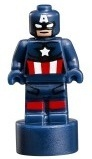
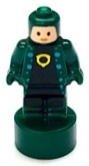
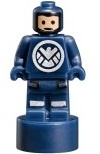
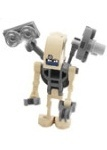
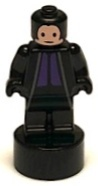

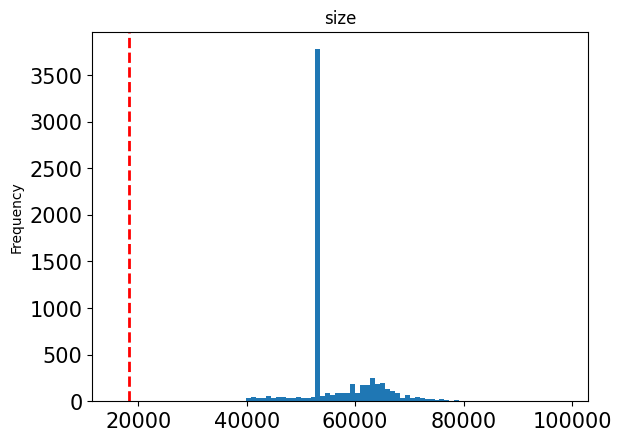

In [27]:
# Create visualization of images stastics (for example blur)
metric = 'size'
fastdup.create_stats_gallery(
    'fastdup/run', 
    save_path='fastdup/analysis',
    metric=metric,
    num_images=10,
)
HTML(filename=f'fastdup/analysis/{metric}.html')